In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve ,train_test_split
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import *
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
random_state=7

# Load data

In [75]:
trainData = pd.read_csv('data\\train.csv',index_col='Id')
testData = pd.read_csv('data\\test.csv',index_col='Id')
trainData.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [79]:
trainData.columns.get_loc("MSSubClass")

0

# Exploratory Data Analysis (EDA)

## Analyse de la forme

In [3]:
print(f'le jeu de données a {trainData.shape[0]} lignes et {trainData.shape[1]} colonnes.\nLa target du dataset est la variable SalePrice. On a donc {trainData.shape[1]-1} variables qui explique les prix des logements.')

le jeu de données a 1460 lignes et 80 colonnes.
La target du dataset est la variable SalePrice. On a donc 79 variables qui explique les prix des logements.


In [4]:
trainTargetData = trainData['SalePrice']
trainFeaturesData = trainData.drop('SalePrice',axis=1)

In [5]:
# identification des variables numerique et categorical
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
numericalFeatures = []
categoricalFeatures = []
colNames = trainFeaturesData.columns
for i in colNames:
    if is_numeric_dtype(trainFeaturesData[i]):
        numericalFeatures.append(i)
    elif is_string_dtype(trainFeaturesData[i]):
        categoricalFeatures.append(i)

print(f'On a donc {len(categoricalFeatures)} variables catégorielle : \n \n {categoricalFeatures} \n \n et {len(numericalFeatures)} numerique : \n \n {numericalFeatures} .')

On a donc 43 variables catégorielle : 
 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'] 
 
 et 36 numerique : 
 
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBl

In [6]:
# recherche des données manquantes
colNames = trainFeaturesData.columns
count = 0
nanVarInfo = {}
for i in colNames:
    count =  trainFeaturesData[[i]].isna().sum().sum()
    if count != 0:
        nanVarInfo[i] = count
nanVarInfo

{'LotFrontage': 259,
 'Alley': 1369,
 'MasVnrType': 8,
 'MasVnrArea': 8,
 'BsmtQual': 37,
 'BsmtCond': 37,
 'BsmtExposure': 38,
 'BsmtFinType1': 37,
 'BsmtFinType2': 38,
 'Electrical': 1,
 'FireplaceQu': 690,
 'GarageType': 81,
 'GarageYrBlt': 81,
 'GarageFinish': 81,
 'GarageQual': 81,
 'GarageCond': 81,
 'PoolQC': 1453,
 'Fence': 1179,
 'MiscFeature': 1406}

### On remarque que les variables Alley(Type de ruelle d'accès à la propriété),PoolQC(Qualité de la piscine),Fence(Qualité de la clôture et MiscFeature(Fonctionnalité diverse non couverte dans d'autres catégories) ont plus 1/3 de champ vide. On peut envisager de les éliminer.

## Analyse du fond

### Visualisation de la target

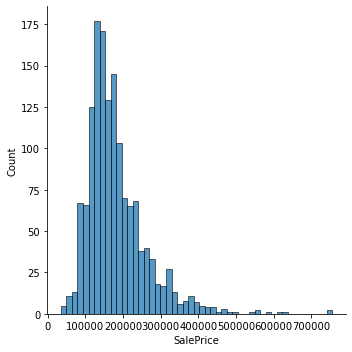

In [7]:
sns.displot(trainTargetData)

#### La variable target suit une distribution exponentielle. Les logements ont en moyenne un prix de 150000.

### Visualisation des outliers

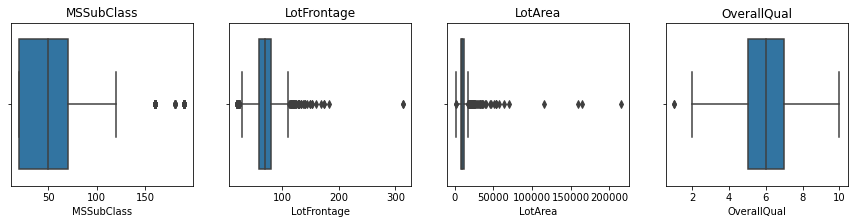

In [8]:
### visualisation des outliers
count = 0
fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
fig.suptitle('')

for i in numericalFeatures[0:4]:
    sns.boxplot(ax=axes[count],x=i,data=trainFeaturesData)
    axes[count].set_title(i)
    count = count + 1

#### En visualisant seulement 4 graphes, on remarque la présence des outliers. Mais dans ce cas les outliers peuvent ne pas être des erreurs. Il se peut que dans tous les logements il y’a seulement un logement qui a un plus grand jardin ou un grand garage.

# Preprocessing

#### D'après l'étape précédente on procède comme suit :

## Elimination et Remplacement des valeurs manquantent

In [9]:
# recherche des données manquantes
colNames = trainFeaturesData.columns
count = 0
nanVarInfo = {}
for i in colNames:
    count =  trainFeaturesData[[i]].isna().sum().sum()
    if count != 0:
        nanVarInfo[i] = count
nanVarInfo

{'LotFrontage': 259,
 'Alley': 1369,
 'MasVnrType': 8,
 'MasVnrArea': 8,
 'BsmtQual': 37,
 'BsmtCond': 37,
 'BsmtExposure': 38,
 'BsmtFinType1': 37,
 'BsmtFinType2': 38,
 'Electrical': 1,
 'FireplaceQu': 690,
 'GarageType': 81,
 'GarageYrBlt': 81,
 'GarageFinish': 81,
 'GarageQual': 81,
 'GarageCond': 81,
 'PoolQC': 1453,
 'Fence': 1179,
 'MiscFeature': 1406}

#### On est déjà passé par là dans l'étape précédente, on supprime donc les variables qui ont 1/3 de champ vide.

In [10]:
# Eliminer des variables
trainFeaturesData = trainFeaturesData.drop(['Alley','Fence','MiscFeature','PoolQC'],axis=1)

#### Le dataset a des variables numériques et des variables catégorielles. On va remplacer les valeurs manquantes par la moyenne pour les variables numérique et par la valeur la plus fréquente pour les variables catégorielles.

In [11]:
# On va regrouper les numericalFeatures et les categoricalFeatures
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

numericalFeatures = []
categoricalFeatures = []
colNames = trainFeaturesData.columns
for i in colNames:
    if is_numeric_dtype(trainFeaturesData[i]):
        numericalFeatures.append(i)
    elif is_string_dtype(trainFeaturesData[i]):
        categoricalFeatures.append(i)

### Elimination des valeurs numérique

In [12]:
# Remplacer les valeurs manquantes par la moyenne
numerical_imputer = SimpleImputer(strategy='mean')
numerical_imputer.fit(trainFeaturesData[numericalFeatures])
trainFeaturesData[numericalFeatures] = numerical_imputer.transform(trainFeaturesData[numericalFeatures])

In [13]:
# Normalisation des données
scaler = StandardScaler()
trainFeaturesData[numericalFeatures] = scaler.fit_transform(trainFeaturesData[numericalFeatures])

### Elimination des valeurs categorielle

In [14]:
# Remplacer les vides par les valeurs les plus frequentes
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_imputer.fit(trainFeaturesData[categoricalFeatures])
trainFeaturesData[categoricalFeatures] = categorical_imputer.transform(trainFeaturesData[categoricalFeatures])

In [15]:
# Encodage de des valeurs cateorielle
for i in categoricalFeatures:
    encoder = LabelEncoder()
    trainFeaturesData[i] = encoder.fit_transform(trainFeaturesData[i])

# Modeling

#### Dans ce Exemple on va travailler avec l'algorithme de decision tree regressor.

## Simple modeling

### Cross validation

In [16]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [17]:
model = DecisionTreeRegressor(random_state=random_state)

In [18]:
cv_result = cross_val_score(model, trainFeaturesData,trainTargetData, scoring = "r2", cv = kfold, n_jobs=4)
cv_means = cv_result.mean()
cv_std = cv_result.std()

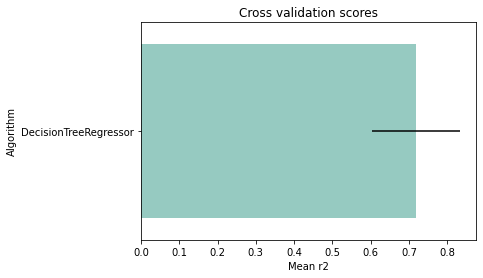

In [19]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTreeRegressor"]})
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean r2")
g = g.set_title("Cross validation scores")

In [20]:
print(f'le model a donc une precision de {cv_means} ce qui est pas mal pour une cross validation')

le model a donc une precision de 0.7188842695856607 ce qui est pas mal pour une cross validation


### Verifions si le model fait de l'overfiting

In [21]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
                        
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

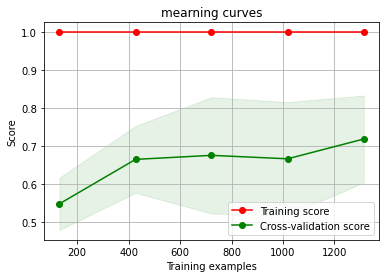

In [22]:
g = plot_learning_curve(model,"mearning curves",trainFeaturesData,trainTargetData,cv=kfold)

### Il y’a une grande marche entre la courbe du train et celle de cross-validation. Le modèle fait de l'overfiting. Avec les meilleurs paramètres et en limitant la profondeur l'arbre on peut éviter le surajustement.

### Recherche des meilleurs paramètres.

In [30]:
param_grid = {
    'max_depth':np.arange(1,20),
    'criterion':['mse', 'mae']
}
grid = GridSearchCV(DecisionTreeRegressor(random_state=random_state),param_grid,cv=kfold, scoring="r2", n_jobs= 4)
grid.fit(trainFeaturesData,trainTargetData)
grid.best_score_

0.7786217467959149

In [31]:
grid.best_params_

{'criterion': 'mse', 'max_depth': 5}

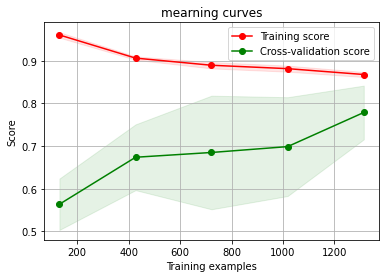

In [32]:
g = plot_learning_curve(grid.best_estimator_,"mearning curves",trainFeaturesData,trainTargetData,cv=kfold)

#### Le modéle est plus performant, il se généralise avec un max_depth:5 et criterion:mse

## Pipeline Modeling

In [33]:
target = trainData['SalePrice']
features = trainData.drop('SalePrice',axis=1)
features = features.drop(['Alley','Fence','MiscFeature','PoolQC'],axis=1)

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

numericalFeatures = []
categoricalFeatures = []
colNames = features.columns
for i in colNames:
    if is_numeric_dtype(features[i]):
        numericalFeatures.append(i)
    elif is_string_dtype(features[i]):
        categoricalFeatures.append(i)

In [34]:
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'),StandardScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder())

In [35]:
from sklearn.compose import make_column_transformer
preprocessor = make_column_transformer((numerical_pipeline,numericalFeatures),(categorical_pipeline,categoricalFeatures))

In [36]:
tree_pipeline = make_pipeline(preprocessor,DecisionTreeRegressor(criterion= 'mse', max_depth= 5,random_state=random_state))
tree_pipeline.fit(features,target)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1st...
     

# Evaluation du modèle

In [37]:
X_train,X_test,y_train,y_test = train_test_split(trainFeaturesData,trainTargetData,test_size=0.2)

In [39]:
tree = grid.best_estimator_
tree.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=5, random_state=7)

In [40]:
mean_absolute_error(y_test,tree.predict(X_test))

28126.2460874497

In [41]:
median_absolute_error(y_test,tree.predict(X_test))

18140.811320754714

In [42]:
26023.265670145185 - 19156.008281292423

6867.257388852762

#### Il y'a une grande difference entre la mean absolute error et la median absolute error. Cette différence est la cause de présence des outliers.

# Export Model

#### On va exporter le pipeline pour automatiquement faire le preprocessing avec des nouvelles données.

In [43]:
from joblib import load
import joblib
joblib.dump(tree_pipeline, 'model.joblib')

['model.joblib']

In [44]:
savedModel = load('model.joblib')

# Submission

In [45]:
testData = testData.drop(['Alley','Fence','MiscFeature','PoolQC'],axis=1)
testData.shape

(1459, 75)

In [48]:
result = savedModel.predict(testData)
result = result.reshape(result.shape[0],1)

In [47]:
submissiondata = pd.read_csv('data\\sample_submission.csv',index_col='Id')
submissiondata.head()

,SalePrice
Id,
1461,169277.052498
1462,187758.393989
1463,183583.683570
1464,179317.477511
1465,150730.079977


In [49]:
submissiondata[['SalePrice']] = result
submissiondata.to_csv('submission.csv')

In [50]:
! kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Prediction with decision Tree Model"

Successfully submitted to House Prices - Advanced Regression Techniques

  0%|          | 0.00/31.4k [00:00<?, ?B/s]
 25%|██▌       | 8.00k/31.4k [00:00<00:02, 9.08kB/s]
 51%|█████     | 16.0k/31.4k [00:01<00:01, 12.4kB/s]
100%|██████████| 31.4k/31.4k [00:03<00:00, 8.87kB/s]


# Prediction function

#### On va creer une fonction de prediction et de suggestion en meme temps. La fonction prendra comme paramettre les 75 variables ce qui est beaucoup. Dans ce cas L'utilisateur peut utiliser le nombre de variable qu'il veut et les variables manquante seront remplacer par la moyenne ou la valeur la plus frequente.
Pour les suggestion nous utiliseront la valeur predicte.

In [52]:
# Pour chaque variables numerique on va recuperer leur moyennes et pour les variables categorielle la valeur la plus frequente
columnsName = trainData.columns
columnsValue = {}
for col in columnsName:
    if is_numeric_dtype(trainData[col]):
        columnsValue[col] = round(trainData[[col]].mean().sum())
    elif is_string_dtype(trainData[col]):
        columnsValue[col] = trainData[col].value_counts().idxmax()

In [54]:
import json
with open('result.json', 'w') as fp:
    json.dump(columnsValue, fp)

In [55]:
# Opening JSON file 
with open('result.json') as json_file: 
    jsonData = json.load(json_file) 
    # Print the type of data variable 
    print("Type:", type(jsonData)) 

Type: <class 'dict'>


In [113]:
importedModel = load('model.joblib')
def predictHousePrice(columnsValue,predictData,interval=1000):
    # Prediction
    globalpredictData = {}
    for var in columnsValue:
        if var in predictData:
            globalpredictData[var] = [predictData[var]]
        else:
            globalpredictData[var] = [columnsValue[var]]
    predictValue = pd.DataFrame(globalpredictData)
    price = round(importedModel.predict(predictValue)[0])

    # Filter database
    database = pd.read_csv('data\\train.csv',index_col='Id')
    database = database.drop(['Alley','Fence','MiscFeature','PoolQC'],axis=1)
    # for key,value in predictData.items():
    #     index = database.columns.get_loc(key)
    #     database = database[(database.iloc[:,index] == value)]
    target_index = database.columns.get_loc('SalePrice')
    database = database[(database.iloc[:,target_index]>price-interval) & (database.iloc[:,target_index]<price+interval)]
    return price ,database

In [115]:
predictData = {'MSSubClass': 60,'LotFrontage': 65,'YrSold': 2005}
price ,suggestions = predictHousePrice(columnsValue,predictData)
price

181321

In [116]:
suggestions

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
56,20,RL,100.0,10175,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,407,0,0,0,7,2008,WD,Normal,180500
125,20,RL,48.0,17043,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,1,2009,WD,Normal,181000
206,20,RL,99.0,11851,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,508,0,0,0,5,2009,WD,Normal,180500
416,20,RL,73.0,8899,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,New,Partial,181134
434,60,RL,100.0,10839,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,7,2008,WD,Normal,181000
581,20,RL,NaN,14585,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,6,2007,WD,Normal,181900
811,20,RL,78.0,10140,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,648,0,1,2006,WD,Normal,181000
974,20,FV,95.0,11639,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,12,2008,New,Partial,182000
